In [1]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.spatial import distance
import pathlib
import os
from sklearn.decomposition import PCA
import json
import random
from random import sample

random.seed(30)

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
# Import the guide-level profiles
df_guide = pd.read_csv("outputs/20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_guide_normalized_merged_feature_select_median_ALLWELLS_1_2.csv.gz")
# Subset the nontargeting guide profiles 
df_nontargeting = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting'")

# Load hits from the hit calling process
whole_cell_hits = pd.read_csv('outputs/HeLa_SABER_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')
comp_spec_hits = pd.read_csv('outputs/HeLa_SABER_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')
all_hits = pd.concat([whole_cell_hits,comp_spec_hits])
hit_list = list(comp_spec_hits.Gene) + list(whole_cell_hits.Gene)
whole_cell_hit_list = list(whole_cell_hits.Gene)
comp_spec_hit_list = list(comp_spec_hits.Gene)

# list non hit genes
all_genes_list = list(df_guide.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
all_genes_list.remove("nontargeting")
non_hit_list = [gene for gene in all_genes_list if gene not in hit_list]
groups = ['Whole cell hit','Compartment hit','Non hit','All gene']
groups_dic = {'Whole cell hit':whole_cell_hit_list,'Compartment hit':comp_spec_hit_list,'Non hit':non_hit_list,'All gene':all_genes_list}
print("All genes:",len(all_genes_list),"non-hit genes",len(non_hit_list),'Whole cell hits',len(whole_cell_hit_list),'Compartment hits',len(comp_spec_hit_list))


All genes: 590 non-hit genes 206 Whole cell hits 306 Compartment hits 78


In [4]:
df_temp = df_guide.copy(deep=True)
features = list(df_guide.columns)
gene_list = list(df_temp.Metadata_Foci_Barcode_MatchedTo_GeneCode)
df_temp = df_temp.drop('Metadata_Foci_Barcode_MatchedTo_GeneCode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_Barcode')
df_temp = df_temp.reset_index()
df_temp["Metadata_Foci_Barcode_MatchedTo_GeneCode"] = gene_list
df_temp = df_temp[features]
df_temp

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_1,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,...,Nuclei_Texture_SumEntropy_Syto9_10_03_256,Nuclei_Texture_SumEntropy_btubulin_10_01_256,Nuclei_Texture_SumVariance_Calnexin_10_01_256,Nuclei_Texture_SumVariance_NfKb_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_00_256,Nuclei_Texture_SumVariance_Syto9_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_01_256,Nuclei_Texture_SumVariance_TDP43_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_03_256,Nuclei_Texture_Variance_Syto9_10_01_256
0,AARS2,AAAGGCGGCCCTCACGGCCG,-0.052235,-0.158375,0.013107,-0.100975,-0.163630,0.189520,0.285264,0.125879,...,-0.301305,-0.026015,-0.422110,-0.436075,-0.328195,-0.294850,0.181285,0.130507,0.198450,-0.292855
1,AARS2,AGCAAACTGGGGTCGCCGCG,-0.258900,-0.459740,-0.272072,-0.060422,-0.397970,0.081770,-0.033692,0.056625,...,-0.491365,-0.659530,-0.478125,-0.226015,-0.372045,-0.458385,-0.075922,0.011385,0.051656,-0.447315
2,AARS2,CCAACTTCTACGCAGAACAG,-0.132880,-0.252800,0.099935,0.130246,0.048945,-0.025845,-0.033111,0.097072,...,-0.579905,-0.419715,-0.291180,-0.236695,-0.223783,-0.305315,0.158725,0.008738,0.000045,-0.240930
3,AARS2,GCTGAGCCAGTTCAGAAGCA,0.023685,0.187520,0.034279,-0.255330,0.678388,-0.058525,-0.052645,-0.016378,...,-0.199930,-0.628520,-0.509130,-0.422055,-0.499170,-0.543055,-0.082475,0.050340,0.046263,-0.523410
4,AARSD1,ACCTCCGCTCCCAATCTACC,0.246670,-0.368480,-0.168987,0.040285,-0.057675,0.577885,0.510590,0.619805,...,-0.472220,0.350025,-0.285700,-0.310835,-0.825055,-0.658360,-0.260640,-0.189415,0.186295,-0.276285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,nontargeting,TAAGATCCGCGGGTGGCAAC,0.304885,0.178550,-0.198601,0.273680,0.202490,-1.244100,-0.728195,-0.646360,...,0.549655,0.474175,0.560410,0.154985,0.141940,0.532435,0.557760,0.352925,0.373555,0.429580
2396,nontargeting,TCCCGGTTGGTGAACGATAC,-0.266702,-0.608585,-0.530960,-0.001097,-0.284394,-0.058880,0.266767,0.231285,...,-0.362107,-0.478795,-0.196041,-0.314249,-0.301765,-0.306024,0.206455,0.034544,0.052445,-0.406645
2397,nontargeting,TGCCGTGAAAAGACGCTGCG,0.439795,-0.475410,-0.097035,0.043919,-0.068639,0.464080,0.092188,0.296787,...,-0.435390,-0.297345,-0.379060,-0.375630,-0.512320,-0.335140,0.150539,-0.028893,0.091351,-0.527665
2398,nontargeting,TGGCCACGAATTCCGCCGCC,0.334780,0.366528,-0.257825,-0.370588,-0.140465,0.078908,0.190906,0.201455,...,-0.329340,-0.501910,-0.291045,-0.291190,0.042340,-0.101190,0.230875,0.110184,0.282550,-0.207045


In [5]:
df_temp = df_guide.drop('Metadata_Foci_Barcode_MatchedTo_GeneCode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_Barcode')
# Perform principal component analysis on hit list
pca = PCA()
pca.fit(df_temp)
x = list(pca.explained_variance_ratio_)
# Find principal component that represents 90% variation
PCA_lookup = {}
for i in range(len(x)):
    distance = abs(.9-sum(x[:i+1]))
    PCA_lookup[distance] = i 
component = PCA_lookup[min(PCA_lookup.keys())]+1
print (f'Principal component representing closest to 90% variation is {component}')
# Perform principal component analysis and select components representing 90% of variation in data
pca = PCA(n_components=component)
df_guide_pca = pd.DataFrame(pca.fit_transform(df_temp),index=df_temp.index)
df_guide_pca.head()

Principal component representing closest to 90% variation is 126


,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
Metadata_Foci_Barcode_MatchedTo_Barcode,,,,,,,,,,,,,,,,,,,,,
AAAGGCGGCCCTCACGGCCG,-6.710463,0.486999,-11.986185,-1.667203,3.587151,1.954251,0.393956,-1.381604,0.795512,2.432747,...,0.361773,-0.007839,-0.245011,0.034276,0.707678,-0.057018,-0.524676,0.119394,0.370013,-0.635075
AGCAAACTGGGGTCGCCGCG,-5.440888,4.873270,-6.463723,0.125317,5.979666,-1.431571,3.642431,-4.030995,-5.560010,-0.650523,...,-0.101165,0.666738,-0.047352,-0.744419,0.446993,-0.052027,-0.172454,0.408679,-0.279088,-0.351466
CCAACTTCTACGCAGAACAG,-2.895954,2.082860,-7.397230,-1.212867,5.571158,0.768329,2.529835,-4.745525,-4.228630,-0.546666,...,0.205649,0.102374,0.019511,-0.908715,0.556679,-0.135004,-0.144798,-0.155011,-0.695308,-0.207502
GCTGAGCCAGTTCAGAAGCA,-5.137854,8.752760,-7.682749,3.428363,5.618810,3.298196,-1.713082,-1.751437,-6.638270,-1.076689,...,0.246160,0.576478,0.386371,-0.267591,0.016403,0.148501,-0.820566,0.093018,-0.373921,-0.460749
ACCTCCGCTCCCAATCTACC,-9.430923,-13.188477,-1.666126,-0.493579,0.709127,-4.454061,-2.674309,2.788512,-4.126509,-5.779795,...,-0.468873,-0.530320,0.001649,-0.110787,0.371724,0.647760,0.626009,0.482382,-0.331252,-0.115339


In [6]:
df_guide_pca_updated = df_guide_pca.reset_index()
pca_feat_list = list(df_guide_pca_updated.columns)
feat_list = ['Metadata_Foci_Barcode_MatchedTo_GeneCode']
feat_list.extend(pca_feat_list)
df_guide_pca_updated["Metadata_Foci_Barcode_MatchedTo_GeneCode"] = gene_list
df_guide_pca_updated = df_guide_pca_updated[feat_list]
df_guide_pca_updated

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,0,1,2,3,4,5,6,7,...,116,117,118,119,120,121,122,123,124,125
0,AARS2,AAAGGCGGCCCTCACGGCCG,-6.710463,0.486999,-11.986185,-1.667203,3.587151,1.954251,0.393956,-1.381604,...,0.361773,-0.007839,-0.245011,0.034276,0.707678,-0.057018,-0.524676,0.119394,0.370013,-0.635075
1,AARS2,AGCAAACTGGGGTCGCCGCG,-5.440888,4.873270,-6.463723,0.125317,5.979666,-1.431571,3.642431,-4.030995,...,-0.101165,0.666738,-0.047352,-0.744419,0.446993,-0.052027,-0.172454,0.408679,-0.279088,-0.351466
2,AARS2,CCAACTTCTACGCAGAACAG,-2.895954,2.082860,-7.397230,-1.212867,5.571158,0.768329,2.529835,-4.745525,...,0.205649,0.102374,0.019511,-0.908715,0.556679,-0.135004,-0.144798,-0.155011,-0.695308,-0.207502
3,AARS2,GCTGAGCCAGTTCAGAAGCA,-5.137854,8.752760,-7.682749,3.428363,5.618810,3.298196,-1.713082,-1.751437,...,0.246160,0.576478,0.386371,-0.267591,0.016403,0.148501,-0.820566,0.093018,-0.373921,-0.460749
4,AARSD1,ACCTCCGCTCCCAATCTACC,-9.430923,-13.188477,-1.666126,-0.493579,0.709127,-4.454061,-2.674309,2.788512,...,-0.468873,-0.530320,0.001649,-0.110787,0.371724,0.647760,0.626009,0.482382,-0.331252,-0.115339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,nontargeting,TAAGATCCGCGGGTGGCAAC,4.003927,-18.131483,-5.699261,-16.737475,-4.544329,5.003279,3.466993,5.139113,...,0.178405,0.548356,-0.843036,0.641421,-0.650784,0.547580,0.525215,-0.240764,0.394373,0.642723
2396,nontargeting,TCCCGGTTGGTGAACGATAC,-3.796607,1.166612,-8.339153,-3.137942,4.600958,0.103040,4.956599,-0.998438,...,-1.153164,0.574356,-0.928592,0.217662,0.194705,-0.341822,0.002080,-0.086021,0.018338,-0.886798
2397,nontargeting,TGCCGTGAAAAGACGCTGCG,-4.889959,0.596805,-9.629494,-3.326799,1.445863,-1.743408,2.061291,1.434181,...,-0.174679,0.437433,-0.606030,0.461831,0.440714,0.482774,0.028372,0.172509,-0.264851,-0.042973
2398,nontargeting,TGGCCACGAATTCCGCCGCC,-5.551520,2.499135,-7.366429,-5.081633,1.432936,1.231327,1.764526,-1.644413,...,0.073212,-0.341470,0.046859,-0.472855,0.414064,-0.108948,-0.798668,0.090271,-0.109718,-0.740431


In [7]:
def calculate_mean_similarity(cosine_array):
    total_sum = 0
    for i in range(4):
        similarities = cosine_array[i]
        target_sum = 0
        for j in range(4):
            target_sum += similarities[j]  
        target_mean = ((target_sum-1)/3)
        total_sum += target_mean

    total_mean = total_sum / 4
    return total_mean

hit_guide_sim_list =[]
for i in range(len(whole_cell_hit_list)):
    df_temp = df_guide_pca_updated.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == @whole_cell_hit_list[@i]")
    df_temp = df_temp.drop(['Metadata_Foci_Barcode_MatchedTo_Barcode'],axis=1)
    df_temp = df_temp.set_index("Metadata_Foci_Barcode_MatchedTo_GeneCode")
    cosine_array = cosine_similarity(df_temp)
    hit_guide_sim = calculate_mean_similarity(cosine_array)
    hit_guide_sim_list.append(hit_guide_sim)
average_cosine_distance = sum(hit_guide_sim_list)/len(hit_guide_sim_list)
print('Average cosine distance: ',average_cosine_distance)

Average cosine distance:  0.5700225863618966


In [8]:
def cosine_to_df(df_temp, cosine_array, i):
    cosine_list = cosine_array[i]
    gene_list = list(df_temp.index)
    cosine_df = pd.DataFrame(index=gene_list)
    cosine_df['cosine'] = cosine_list
    cosine_df = cosine_df.sort_values('cosine',ascending=False)   
    return cosine_df

def ap_from_cosine_df(cosine_df,gene,n=10):    
    #print(cosine_df.iloc[:20])
    index_list = list(cosine_df.index)
    boolean = [1 if  i == gene else 0 for i in index_list ]
    grades_list=[]
    for i in range(2,n+2):
        pre_grade = sum(boolean[1:i])/(i-1)
        grades_list.append(pre_grade*boolean[i-1])
    return sum(grades_list)/3

def calculate_map(df_guide, gene):
    df_temp = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting' | Metadata_Foci_Barcode_MatchedTo_GeneCode == @gene")
    df_temp = df_temp.drop(['Metadata_Foci_Barcode_MatchedTo_Barcode'],axis=1)
    df_temp = df_temp.set_index("Metadata_Foci_Barcode_MatchedTo_GeneCode")
    #print(df_temp)
    ap_list = []
    cosine_array = cosine_similarity(df_temp)
    for guide in range(4):
        cosine_df = cosine_to_df(df_temp, cosine_array, guide)
        #print(cosine_df[:10])
        guide_ap = ap_from_cosine_df(cosine_df,gene,10)
        ap_list.append(guide_ap)
    return np.mean(ap_list)

In [9]:
df_results = pd.DataFrame(index=list(np.arange(0,len(all_genes_list))),columns=['gene','group','mAP'])
counter = 0
for group in groups:
    for i in range(len(groups_dic[group])):
        gene = groups_dic[group][i]
        gene_map = calculate_map(df_guide_pca_updated, gene)
        df_results.loc[counter,'gene'] = gene
        df_results.loc[counter,'group'] = group
        df_results.loc[counter,'mAP'] = gene_map
        counter+=1

df_results.to_csv(os.path.join(output_folder,'CP498_SABER_1_2_mAP_values.csv'),index=False)
df_results

,gene,group,mAP
0,ABCF1,Whole cell hit,0.587798
1,ACTR2,Whole cell hit,0.90625
2,ACTR3,Whole cell hit,0.9375
3,ALG13,Whole cell hit,0.877083
4,ALG5,Whole cell hit,0.979167
...,...,...,...
1175,YWHAH,All gene,0.412698
1176,ZC3H8,All gene,0.375
1177,ZC3HC1,All gene,0.225
1178,ZNF131,All gene,0.268519


In [10]:
# print out the results in text format
all_genes_df = df_results.query("group == 'All gene'")
whole_cell_hits_df = df_results.query("group == 'Whole cell hit'")
comp_hits_df = df_results.query("group == 'Compartment hit'")
non_hits_df = df_results.query("group == 'Non hit'")

print(f'For all genes ({len(all_genes_df)} genes) the mAP values is',all_genes_df.mAP.mean())
print(f'For whole cell hits ({len(whole_cell_hits_df)} genes) the mAP values is',whole_cell_hits_df.mAP.mean())
print(f'For compartment hits ({len(comp_hits_df)} genes) the mAP values is',comp_hits_df.mAP.mean())
print(f'For non hits ({len(non_hits_df)} genes) the mAP values is',non_hits_df.mAP.mean())

For all genes (590 genes) the mAP values is 0.46948894717962536
For whole cell hits (306 genes) the mAP values is 0.7062189845073832
For compartment hits (78 genes) the mAP values is 0.3085889804639804
For non hits (206 genes) the mAP values is 0.17876470437150047


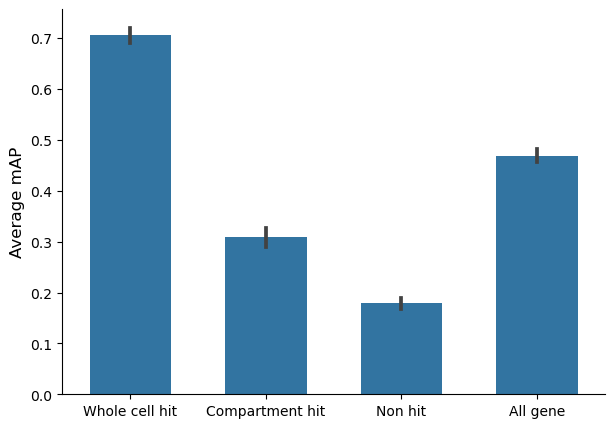

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
errorbar='se'
ax = sns.barplot(data=df_results,
                  x='group', 
                  y='mAP', 
                  errorbar=errorbar,
                  color='tab:blue',
                  width=0.6,
                 )


ax.set_title('',size=14)
ax.set_xlabel(None,size=12)
ax.set_ylabel('Average mAP',size=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(output_folder,'figure_panels','CP498_SABER_1_2_mAP_values_barplot.png'),dpi = 300,bbox_inches='tight')
plt.show()